# Parallelizing HTTP calls using Spark

We're looking for fastest way to make HTTP calls - while being the cheapest (i.e. using least amount of compute or nodes)

In [12]:
number_of_http_calls = 100
test_endpoint = "https://nl-stu-jvw-func.azurewebsites.net/api/echo"
#test_endpoint = "https://httpbin.org/ip"

cores_per_executor = 4
num_executors = 1
dj_margin = 4 # According to Dirk-Jan we need 2 - 4 times nr of cores x executors
partition_count = cores_per_executor * num_executors * dj_margin


StatementMeta(jvwpool, 6, 13, Finished, Available, Finished)

## 1. On the driver - synchronous

- Runs on driver (I think - check with B)
- Runs sequentially: `for .. etc` and blocking call to request.get

**Observations**

- Worst performance - approx 100 x 1sec execution
- Azure function shows 1 req/sec


**Results**
```
Average Response Time: 1.0735 seconds
Overall Response Time for 10 calls: 10.7349 seconds
```

```
Average Response Time: 1.0663 seconds
Overall Response Time for 100 calls: 106.6314 seconds
```

In [3]:
import requests
import time
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setJobGroup("Experiment#1", "Sync on driver")

def call_endpoint_sync_on_driver(endpoint, iterations):
    def call_endpoint(index):  
        try:
            response = requests.get(endpoint)
        
            if response.status_code == 200:
                #print(f"Call {index}: HTTP 200 OK - Response Time: {elapsed_time:.4f} seconds")
                return response.text
            else:
                print(f"Call {index}: HTTP {response.status_code}")
                return None
        except requests.exceptions.RequestException as e:
            print(f"Call {index}: Failed with error: {e}")
            return None

    start_time = time.time()

    for i in range(1, iterations + 1):
        response_time = call_endpoint(i)
    
    elapsed_time = time.time() - start_time
    
    # Log statistics
    print("Function: call_endpoint_sync_on_driver")
    print(f"Overall Response Time for {iterations} calls: {elapsed_time:.2f} seconds")
    return elapsed_time

call_endpoint_sync_on_driver(test_endpoint, number_of_http_calls)

StatementMeta(jvwpool, 5, 4, Finished, Available, Finished)

Function: call_endpoint_sync_on_driver
Overall Response Time for 10 calls: 10.70 seconds


10.704922437667847

## 2. On the driver - asynchronous

- Runs on driver node (I think - check with B)
- BUT: runs async - so parallelized


**Observations**

Approx 4x speed up - while running only on master node. So parellelization WITHOUT need of Spark pool (!)


**Results**
Azure function shows 4 req/sec

```
Overall Response Time for 10 calls: 3.0787 seconds
```

```
Overall Response Time for 100 calls: 15.5005 seconds
```

In [8]:
import aiohttp
import asyncio
import nest_asyncio

nest_asyncio.apply()

spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setJobGroup("Experiment#2", "Async on driver")


async def call_endpoint_async_on_driver(endpoint, iterations):
    async def call_endpoint(session, index):
        try:
            async with session.get(endpoint) as response:           
                if response.status == 200:
                    #print(f"Call {index}: HTTP 200 OK - Response Time: {elapsed_time:.4f} seconds")
                    return response.text
                else:
                    print(f"Call {index}: HTTP {response.status}")
                    return None
        except aiohttp.ClientError as e:
            print(f"Call {index}: Failed with error: {e}")
            return None

    start_time = time.time()

    async with aiohttp.ClientSession() as session:
        tasks = [call_endpoint(session, i) for i in range(1, iterations + 1)]
        results = await asyncio.gather(*tasks)

    elapsed_time = time.time() - start_time
    
    # Log statistics
    print("Function: call_endpoint_async_on_driver")
    print(f"Overall Response Time for {iterations} calls: {elapsed_time:.2f} seconds")
    return elapsed_time

asyncio.run(call_endpoint_async_on_driver(test_endpoint, number_of_http_calls))


StatementMeta(jvwpool, 6, 9, Finished, Available, Finished)

Function: call_endpoint_async_on_driver
Overall Response Time for 100 calls: 12.52 seconds


12.51823377609253

## 3. On the executors - synchronous

- Distributes over worker nodes
- Runs sync on the workder nodes

**Observations**
- Faster than on driver node sync
- Slower (for 10 calls) than purely on driver node. Probably due to overhead of distributuing tasks over worker nodes and gathering results

**Results**
```
Overall Response Time for 10 calls: 7.0602 seconds
```

```
Overall Response Time for 100 calls: 25.8654 seconds
```

In [9]:
from pyspark.sql import session
from pyspark.sql.functions import udf

import pyspark.sql.functions as F

import requests
import random
import string
import time

spark = session.SparkSession.builder \
    .appName("HTTP parallel calls over dataframe") \
    .getOrCreate()
spark.sparkContext.setJobGroup("Experiment#3", "Sync on executors")


def call_endpoint_sync_on_executors(endpoint, iterations):
    def generate_random_names(count):
        return [''.join(random.choices(string.ascii_letters, k=8)) for _ in range(count)]

    def call_endpoint(name):
        try:
            ep = f"{endpoint}?name={name}"
            response = requests.get(ep)
            if response.status_code == 200:
                return response.text
            else:
                return f"Failed for {name} with status code {response.status_code}"
        except Exception as e:
            return f"Error for {name}: {str(e)}"

    call_endpoint_udf = udf(call_endpoint)
    
    random_names = generate_random_names(iterations)
    
    names_df = spark.createDataFrame([(name,) for name in random_names], ["name"])
    
    # Repartition the dataframe to take max advantage of #cores for given dataset
    names_df.repartition(partition_count)
    #names_df.groupBy(F.spark_partition_id()).count().show()

    print(f"Number of partitions: {names_df.rdd.getNumPartitions()}")
    print(f"DF count {names_df.count()}")

    start_time = time.time()    

    result_df = names_df \
        .withColumn("response", call_endpoint_udf(names_df["name"])) \
        .persist()
    
    result_df.collect()
    
    elapsed_time = time.time() - start_time
    
    # Log statistics
    print("Function: call_endpoint_sync_on_executors")
    print(f"Overall Response Time for {iterations} calls: {elapsed_time:.2f} seconds")
    return elapsed_time

call_endpoint_sync_on_executors(test_endpoint, number_of_http_calls)

StatementMeta(jvwpool, 6, 10, Finished, Available, Finished)

Number of partitions: 4
DF count 100
Function: call_endpoint_sync_on_executors
Overall Response Time for 100 calls: 26.91 seconds


26.90829110145569

## 4. On the executors - asynchronous

- Distributes over executors
- Runs async on the executors

**Observations**
- Fastest (together with driver/async)
- Slower (for 10 calls) than purely on driver node. Probably due to overhead of distributuing tasks over worker nodes and gathering results

**Results**

```
Overall Response Time for 100 calls: 14.9272 seconds
```

In [13]:
import random
import string
import time
import asyncio
import aiohttp

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HTTP parallel calls over dataframe (async)") \
    .getOrCreate()
spark.sparkContext.setJobGroup("Experiment#4", "Async on executors")


def call_endpoint_async_on_executors(endpoint, iterations):
    def generate_random_names(count):
        return [''.join(random.choices(string.ascii_letters, k=8)) for _ in range(count)]

    async def call_endpoint(session, url):
        try:
            async with session.get(url) as response:
                if response.status == 200:
                    return await response.text()
                else:
                    return f"Failed with status code {response.status}"
        except Exception as e:
            return f"Error: {str(e)}"

    async def fetch_all(urls):
        async with aiohttp.ClientSession() as session:
            tasks = [asyncio.create_task(call_endpoint(session, url)) for url in urls]
            return await asyncio.gather(*tasks)

    def async_fetch_partition(iterator):
        names = list(iterator)
        if not names:
            return
        
        urls = [f"{endpoint}?name={row[0]}" for row in names]
        
        results = asyncio.run(fetch_all(urls))
        
        for (name,), result in zip(names, results):
            yield (name, result)    
            
    random_names = generate_random_names(iterations)

    names_df = spark.createDataFrame([(name,) for name in random_names], ["name"])

    # Repartition the dataframe to take max advantage of #cores for given dataset
    names_df.repartition(partition_count)
    #names_df.groupBy(F.spark_partition_id()).count().show()
    
    start_time = time.time()
    
    # Apply mapPartitions to do async HTTP calls
    # Here we convert the DataFrame to RDD, map partitions, and then back to DataFrame
    # The schema: name: string, response: string
    
    result_rdd = names_df.rdd.mapPartitions(async_fetch_partition)
    result_df = spark.createDataFrame(result_rdd, schema=["name", "response"]).persist()
    
    # For verification, you can show some results (uncomment if needed)
    result_df.collect()
    
    elapsed_time = time.time() - start_time
    
    # Log statistics
    print("Function: call_endpoint_async_on_executors")
    print(f"Overall Response Time for {iterations} calls: {elapsed_time:.2f} seconds")
    return elapsed_time

call_endpoint_async_on_executors(test_endpoint, number_of_http_calls)

StatementMeta(jvwpool, 6, 14, Finished, Available, Finished)

Function: call_endpoint_async_on_executors
Overall Response Time for 100 calls: 18.20 seconds


18.1979079246521

## Benchmark

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import asyncio

nest_asyncio.apply()

# Define the iterations
#iterations_list = [1,2,4]
iterations_list = [50,100,150]

# Dictionary to store results
results = {
    "Iterations": iterations_list,
    "call_endpoint_sync_on_driver": [],
    "call_endpoint_async_on_driver": [],
    "call_endpoint_sync_on_executors": [],
    "call_endpoint_async_on_executors": []
}

# Define async function to gather results
def gather_results():
    for iterations in iterations_list:
        # Sync on driver
        #sync_on_driver_time = call_endpoint_sync_on_driver(test_endpoint, iterations)
        #results["call_endpoint_sync_on_driver"].append(sync_on_driver_time)
        results["call_endpoint_sync_on_driver"].append(iterations)        
        
        # Async on driver        
        async_on_driver_time = asyncio.run(call_endpoint_async_on_driver(test_endpoint, iterations))
        results["call_endpoint_async_on_driver"].append(async_on_driver_time)
        
        # Sync on executors
        sync_on_executors_time = call_endpoint_sync_on_executors(test_endpoint, iterations)
        results["call_endpoint_sync_on_executors"].append(sync_on_executors_time)
        
        # Async on executors
        async_on_executors_time = call_endpoint_async_on_executors(test_endpoint, iterations)
        results["call_endpoint_async_on_executors"].append(async_on_executors_time)

# Run the async function to populate results
gather_results()

# Convert results to a Pandas DataFrame
df = pd.DataFrame(results)




StatementMeta(jvwpool, 6, 15, Finished, Available, Finished)

Function: call_endpoint_async_on_driver
Overall Response Time for 50 calls: 7.24 seconds
Number of partitions: 4
DF count 50
Function: call_endpoint_sync_on_executors
Overall Response Time for 50 calls: 15.26 seconds
Function: call_endpoint_async_on_executors
Overall Response Time for 50 calls: 9.87 seconds
Function: call_endpoint_async_on_driver
Overall Response Time for 100 calls: 13.51 seconds
Number of partitions: 4
DF count 100
Function: call_endpoint_sync_on_executors
Overall Response Time for 100 calls: 31.73 seconds
Function: call_endpoint_async_on_executors
Overall Response Time for 100 calls: 19.88 seconds
Function: call_endpoint_async_on_driver
Overall Response Time for 150 calls: 21.79 seconds
Number of partitions: 4
DF count 150
Function: call_endpoint_sync_on_executors
Overall Response Time for 150 calls: 41.26 seconds
Function: call_endpoint_async_on_executors
Overall Response Time for 150 calls: 24.86 seconds


StatementMeta(jvwpool, 6, 16, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, c9007cfc-d34a-44b5-8cb0-5395062c578a)

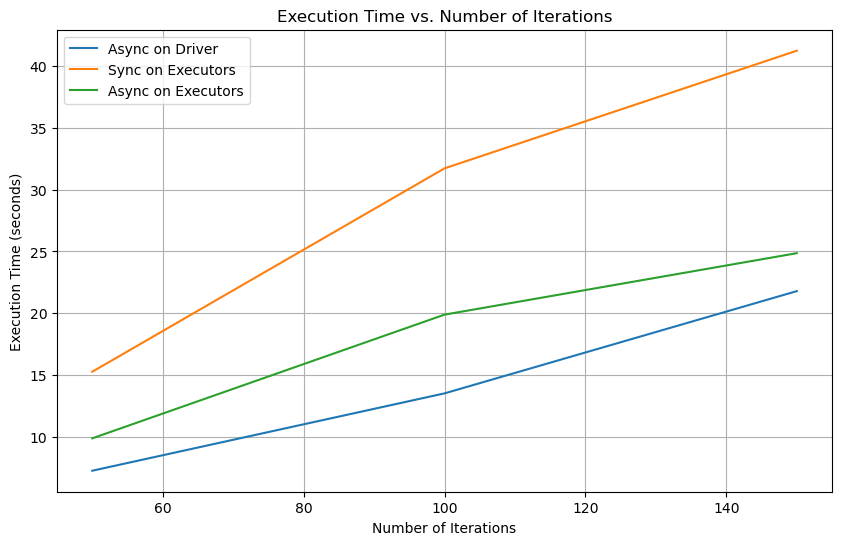

In [15]:
# Display the results as a table
display(df)

# Plot the results
plt.figure(figsize=(10, 6))
#plt.plot(df["Iterations"], df["call_endpoint_sync_on_driver"], label="Sync on Driver")
plt.plot(df["Iterations"], df["call_endpoint_async_on_driver"], label="Async on Driver")
plt.plot(df["Iterations"], df["call_endpoint_sync_on_executors"], label="Sync on Executors")
plt.plot(df["Iterations"], df["call_endpoint_async_on_executors"], label="Async on Executors")

plt.xlabel("Number of Iterations")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time vs. Number of Iterations")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import random
import string
import time
import asyncio
import aiohttp

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("call_endpoint_sync_on_executors_using_mappartition") \
    .getOrCreate()

def call_endpoint_sync_on_executors_using_mappartition(endpoint, iterations):
    def generate_random_names(count):
        return [''.join(random.choices(string.ascii_letters, k=8)) for _ in range(count)]


    def call_endpoint(name):
        try:
            ep = f"{endpoint}?name={name}"
            response = requests.get(ep)
            if response.status_code == 200:
                return response.text
            else:
                return f"Failed for {name} with status code {response.status_code}"
        except Exception as e:
            return f"Error for {name}: {str(e)}"
    
    def fetch_all(urls):
        with aiohttp.ClientSession() as session:
            return [call_endpoint(url) for url in urls]

    def fetch_partition(iterator):
        names = list(iterator)
        if not names:
            return
        
        urls = [f"{endpoint}?name={row[0]}" for row in names]
        fetch_all(urls)
        
        for (name,), result in zip(names, results):
            yield (name, result)    
            
    random_names = generate_random_names(iterations)

    names_df = spark.createDataFrame([(name,) for name in random_names], ["name"])

    # Repartition the dataframe to take max advantage of #cores for given dataset
    cores_per_executor = 4
    num_executors = 5
    names_df.repartition(cores_per_executor * num_executors)
    #names_df.groupBy(F.spark_partition_id()).count().show()
    
    start_time = time.time()
    
    # Apply mapPartitions to do async HTTP calls
    # Here we convert the DataFrame to RDD, map partitions, and then back to DataFrame
    # The schema: name: string, response: string
    
    result_rdd = names_df.rdd.mapPartitions(fetch_partition)
    result_df = spark.createDataFrame(result_rdd, schema=["name", "response"]).persist()
    
    # For verification, you can show some results (uncomment if needed)
    result_df.collect()
    
    elapsed_time = time.time() - start_time
    
    # Log statistics
    print("Function: call_endpoint_sync_on_executors_using_mappartition")
    print(f"Overall Response Time for {iterations} calls: {elapsed_time:.2f} seconds")
    return elapsed_time

call_endpoint_async_on_executors(test_endpoint, number_of_http_calls)

StatementMeta(, , -1, Waiting, , Waiting)